In [10]:
import os, shutil

In [16]:
train_dir = './train/'
validation_dir = './validation/'
test_dir = './test/'

train_cats_dir = './train/cats/'
train_dogs_dir = './train/dogs/'

validation_cats_dir = './validation/cats/'
validation_dogs_dir = './validation/dogs/'

test_cats_dir = './test/cats/'
test_dogs_dir = './test/dogs/'

In [17]:
print('total training images:', len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir)))
print('total validation images:', len(os.listdir(validation_cats_dir)) + len(os.listdir(validation_dogs_dir)))
print('total test images:', len(os.listdir(test_cats_dir)) + len(os.listdir(test_dogs_dir)))

total training images: 2000
total validation images: 1000
total test images: 1000


In [19]:
import matplotlib.pyplot as plt

def plot_accuracy_and_loss(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.show()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

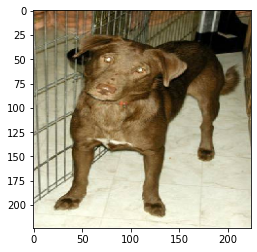

In [22]:
from tensorflow.keras.preprocessing import image
from matplotlib.pyplot import imshow

fnames = [os.path.join(train_dogs_dir, fname) for fname in os.listdir(train_dogs_dir)]
img_path = fnames[1] # Choose one image to view
img = image.load_img(img_path, target_size=(224, 224)) # load image and resize it
x = image.img_to_array(img) # Convert to a Numpy array with shape (224, 224, 3)

x = x.reshape((1,) + x.shape)

plt.imshow(image.array_to_img(x[0]))

In [23]:
from keras.applications.imagenet_utils import decode_predictions
from keras.applications import VGG16

model = VGG16(weights='imagenet', include_top=True)

features = model.predict(x)
decode_predictions(features, top=5)

35363/35363 [==============================] - 0s 1us/step


[[('n02093256', 'Staffordshire_bullterrier', 0.8441076),
  ('n02108915', 'French_bulldog', 0.051072944),
  ('n02110958', 'pug', 0.044878617),
  ('n03935335', 'piggy_bank', 0.027146168),
  ('n02093428', 'American_Staffordshire_terrier', 0.022316884)]]

In [24]:
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
                  include_top=True,
                  input_shape=(224, 224, 3))

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [34]:
from keras import layers, models, optimizers


conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

conv_base.trainable = False

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics=['acc'])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 21,137,729
Trainable params: 6,423,041
Non-trainable params: 14,714,688
_________________________________________________________________


In [27]:
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# The list of classes will be automatically inferred from the subdirectory names/structure under train_dir
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224), # resize all images to 224 x 224
    batch_size=50,
    class_mode='binary') # because we use binary_crossentropy loss we need binary labels

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224), # resize all images to 224 x 224
    batch_size=50,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [33]:
history = model.fit(
    train_generator,
    steps_per_epoch=2, # batches in the generator are 50, so it takes 320 batches to get to 16000 images
    epochs=5,
    validation_data=validation_generator,
    validation_steps=15) # batches in the generator are 50, so it takes 90 batches to get to 4500 images

Epoch 1/5
2/2 [==============================] - 169s 162s/step - loss: 0.5082 - acc: 0.9400 - val_loss: 0.3922 - val_acc: 0.9587
Epoch 2/5
2/2 [==============================] - 173s 162s/step - loss: 0.4312 - acc: 0.9300 - val_loss: 0.3543 - val_acc: 0.9627
Epoch 3/5
2/2 [==============================] - 177s 166s/step - loss: 0.7420 - acc: 0.9200 - val_loss: 0.3097 - val_acc: 0.9667
Epoch 4/5
2/2 [==============================] - 168s 158s/step - loss: 0.6400 - acc: 0.9400 - val_loss: 0.3341 - val_acc: 0.9640
Epoch 5/5
2/2 [==============================] - 175s 164s/step - loss: 0.8027 - acc: 0.9000 - val_loss: 0.3502 - val_acc: 0.9627


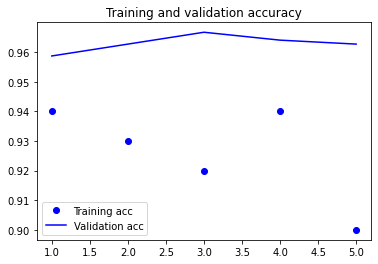

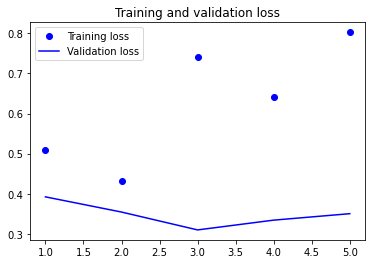

In [35]:
plot_accuracy_and_loss(history)

In [36]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=50,
    class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=90)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.


C:\Users\MIKE~1\AppData\Local\Temp/ipykernel_15764/924241788.py:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model.evaluate_generator(test_generator, steps=90)


test acc: 0.382999986410141


In [37]:
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# The list of classes will be automatically inferred from the subdirectory names/structure under train_dir
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224), # resize all images to 150 x 150
    batch_size=50,
    class_mode='binary') # because we use binary_crossentropy loss we need binary labels

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224), # resize all images to 150 x 150
    batch_size=50,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [38]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [40]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-5),
              metrics=['acc'])

In [44]:
history = model.fit(
    train_generator,
    steps_per_epoch=2, # batches in the generator are 50, so it takes 320 batches to get to 16000 images
    epochs=5,
    validation_data=validation_generator,
    validation_steps=15) # batches in the generator are 50, so it takes 90 batches to get to 4500 images

Epoch 1/5
2/2 [==============================] - 177s 165s/step - loss: 4.8289 - acc: 0.6500 - val_loss: 2.1566 - val_acc: 0.7173
Epoch 2/5
2/2 [==============================] - 176s 162s/step - loss: 3.5532 - acc: 0.6800 - val_loss: 1.8202 - val_acc: 0.7493
Epoch 3/5
2/2 [==============================] - 192s 180s/step - loss: 5.0139 - acc: 0.6300 - val_loss: 1.4913 - val_acc: 0.8013
Epoch 4/5
2/2 [==============================] - 201s 185s/step - loss: 1.1245 - acc: 0.8600 - val_loss: 1.3049 - val_acc: 0.8147
Epoch 5/5
2/2 [==============================] - 202s 187s/step - loss: 1.9691 - acc: 0.7800 - val_loss: 1.2460 - val_acc: 0.8227


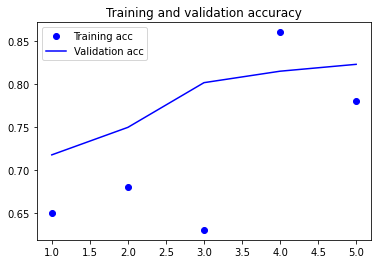

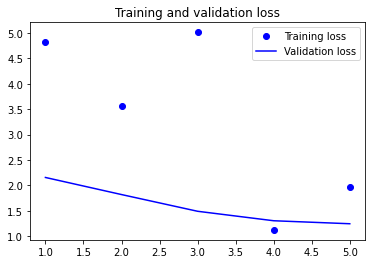

In [47]:
plot_accuracy_and_loss(history)

In [49]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=50,
    class_mode='binary')

test_loss, test_acc = model.evaluate(test_generator, steps=90)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
90/90 [==============================] - 222s 2s/step - loss: 1.0513 - acc: 0.8400
test acc: 0.8399999737739563
